In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
import os
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
img = cv2.imread('source//Warning_2.png')

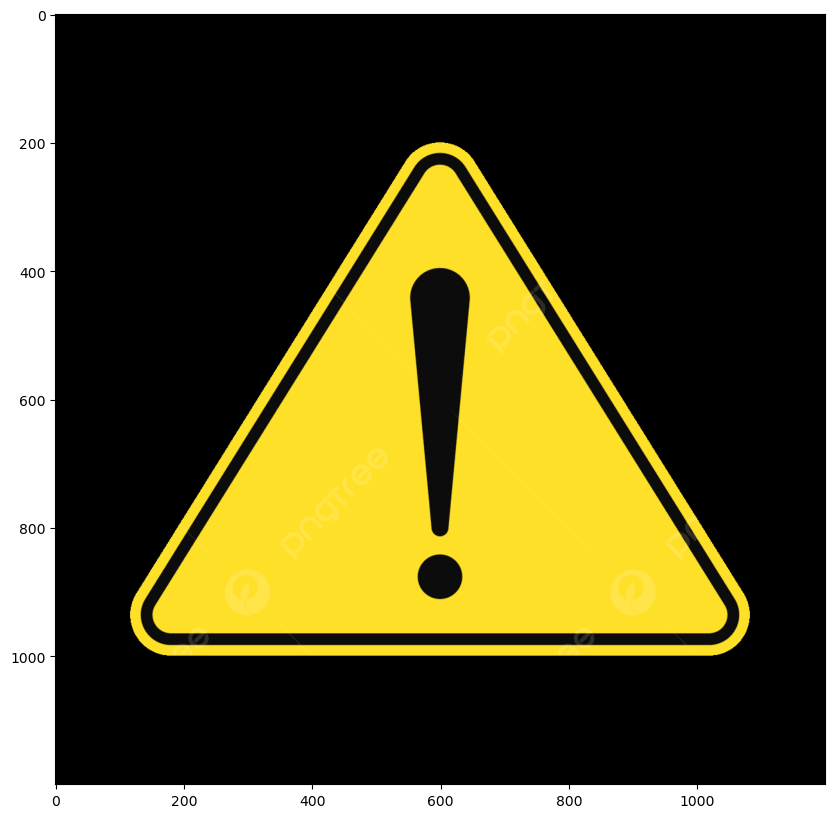

In [3]:
#load and show the camera frame.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=1, fy=1)
plt.imshow(img)

In [4]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [255, 255, 0]])

In [5]:
# Cast the image to float
img = img.astype(float)

In [6]:
# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

In [7]:
# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = colors[np.argmin(np.sum((colors - pixel) ** 2, axis=1))]
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

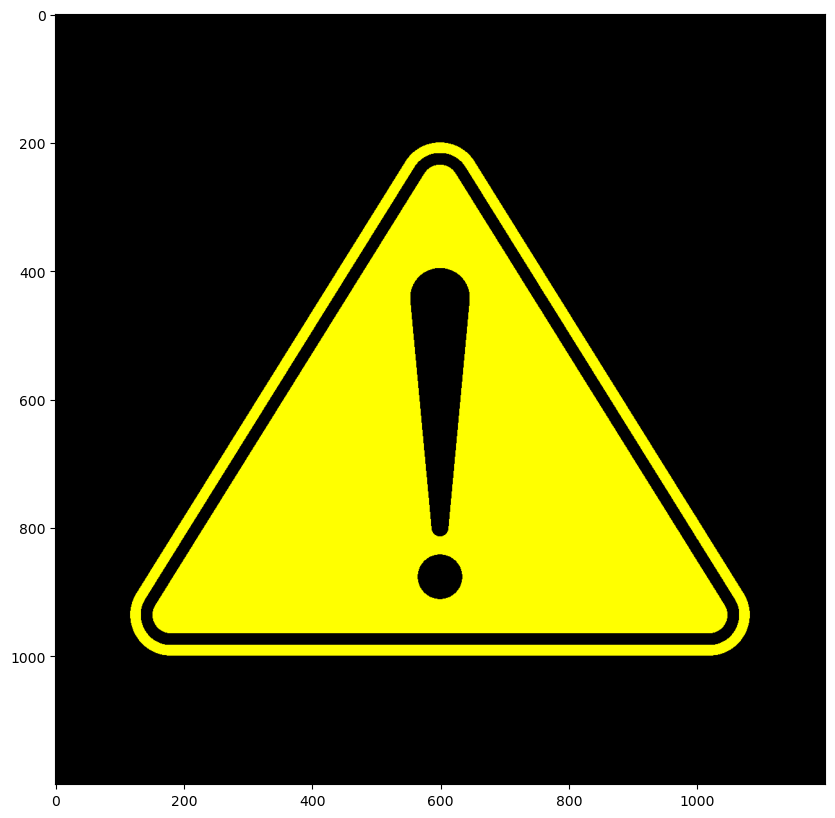

In [8]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(quantized.astype(np.uint8))

In [9]:
# Compute average quantization error
avg_quant_error = np.mean(np.abs(img - quantized))
print(f"Average quantization error: {avg_quant_error}")

Average quantization error: 7.162918287037037


In [10]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

In [ ]:
for r in range(1, rows-1):
    for c in range(1, cols-1):
        pixel = img_tmp[r, c]
                # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = colors[np.argmin(np.sum((colors - pixel) ** 2, axis=1))]
        dithering[r, c] = new_pixel.astype(np.uint8)

        err = pixel - new_pixel
        img_tmp[r,   c+1] = np.clip(img_tmp[r,   c+1] + err * (7/16), 0, 255)
        img_tmp[r+1, c-1] = np.clip(img_tmp[r+1, c-1] + err * (3/16), 0, 255)
        img_tmp[r+1, c  ] = np.clip(img_tmp[r+1, c  ] + err * (5/16), 0, 255)
        img_tmp[r+1, c+1] = np.clip(img_tmp[r+1, c+1] + err * (1/16), 0, 255)
        
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        img_tmp = img_tmp.astype(float)
        
        # Apply dithering
        dithering[r, c, :] = new_pixel

In [ ]:
plt.imshow(dithering.astype(np.uint8))

In [ ]:
# Show quantized image (don't forget to cast back to uint8)
# optimally quantized
plt.subplot(121), plt.imshow(quantized.astype(np.uint8)), plt.title('Quantized')
# dithering
plt.subplot(122), plt.imshow(dithering.astype(np.uint8)), plt.title('Dithering')

In [ ]:
# Compute average quantization error for dithered image
avg_dith_error = np.mean(np.abs(img - dithering))
print(f"Average dithering error: {avg_dith_error}")

- Which image has higher quantization error? Optimally quantized or dithered?
    вища помилка після дитеринга
- Which image looks better to you?
  найкраще, звичайно, оригінальне зображення ... :) , але, якщо мова йде про перетворення із стисканням, то, візуально краще виглядає зображення після дитеринга
  

In [ ]:
###########################################
# Black & white dithering
bw_colors = np.array([[0, 0, 0],
                   [255, 255, 255]])
img_tmp = np.copy(img)
bw_dithering = np.zeros_like(img)
for r in range(1, rows-1):
    for c in range(1, cols-1):
        pixel = img_tmp[r, c]
                # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = bw_colors[np.argmin(np.sum((bw_colors - pixel) ** 2, axis=1))]
        bw_dithering[r, c] = new_pixel.astype(np.uint8)

        err = pixel - new_pixel
        img_tmp[r,   c+1] = np.clip(img_tmp[r,   c+1] + err * (7/16), 0, 255)
        img_tmp[r+1, c-1] = np.clip(img_tmp[r+1, c-1] + err * (3/16), 0, 255)
        img_tmp[r+1, c  ] = np.clip(img_tmp[r+1, c  ] + err * (5/16), 0, 255)
        img_tmp[r+1, c+1] = np.clip(img_tmp[r+1, c+1] + err * (1/16), 0, 255)
        
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        img_tmp = img_tmp.astype(float)
        
        # Apply dithering
        bw_dithering[r, c, :] = new_pixel

plt.imshow(bw_dithering.astype(np.uint8))

In [ ]:
plt.subplot(131), plt.imshow(quantized.astype(np.uint8)), plt.title('Quantized')
# dithering
plt.subplot(132), plt.imshow(dithering.astype(np.uint8)), plt.title('Dithering')
# Black&white dithering
plt.subplot(133); plt.imshow(bw_dithering.astype(np.uint8)), plt.title('Blac&White_Dithering')

In [ ]:
###########################################
# Clustered dithering


from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 3)))
k_colors = kmeans.cluster_centers_

In [ ]:
print(k_colors)

In [ ]:
C = np.clip(np.round(k_colors), 0, 255).astype(np.uint8)

cols, cell = 4, 40
rows = int(np.ceil(len(C)/cols))
grid = np.zeros((rows*cell, cols*cell, 3), dtype=np.uint8)
for i, col in enumerate(C):
    r, c = divmod(i, cols)
    grid[r*cell:(r+1)*cell, c*cell:(c+1)*cell] = col

plt.imshow(grid); plt.axis('off'); plt.show()

In [ ]:
img_tmp = img.astype(np.float32).copy()
k_dithering = np.zeros_like(img, dtype=np.uint8)
rows, cols = img.shape[:2]

for r in range(1, rows-1):
    for c in range(1, cols-1):
        pixel = img_tmp[r, c]
        # найближчий колір із кластерних центроїдів
        new_pixel = k_colors[np.argmin(np.sum((k_colors - pixel) ** 2, axis=1))]
        k_dithering[r, c] = new_pixel.astype(np.uint8)

        # FS-розсіювання помилки (вектор по 3 каналах)
        err = pixel - new_pixel
        img_tmp[r,   c+1] = np.clip(img_tmp[r,   c+1] + err * (7/16), 0, 255)
        img_tmp[r+1, c-1] = np.clip(img_tmp[r+1, c-1] + err * (3/16), 0, 255)
        img_tmp[r+1, c  ] = np.clip(img_tmp[r+1, c  ] + err * (5/16), 0, 255)
        img_tmp[r+1, c+1] = np.clip(img_tmp[r+1, c+1] + err * (1/16), 0, 255)

plt.imshow(k_dithering.astype(np.uint8)); plt.axis('off')

In [ ]:
###########################################
# Звіт

plt.subplot(221), plt.imshow(quantized.astype(np.uint8)), plt.title('Quantized'); plt.axis('off')
# dithering
plt.subplot(222), plt.imshow(dithering.astype(np.uint8)), plt.title('Dithering'); plt.axis('off')
# Black&white dithering
plt.subplot(223); plt.imshow(bw_dithering.astype(np.uint8)), plt.title('Blac&White_Dithering'); plt.axis('off')
# Clustered dithering
plt.subplot(224); plt.imshow(k_dithering.astype(np.uint8)); plt.title('Clustered_Dithering'); plt.axis('off')